(Air_passengers-Prophet_with_Bayesian_workflow)=
# Air passengers - Prophet-like model

:::{post} April, 2022
:tags: time series, prophet
:category: intermediate
:author: Marco Gorelli
:::

We're going to look at the "air passengers" dataset, which tracks the monthly totals of a US airline passengers from 1949 to 1960. We could fit this using the [Prophet](https://facebook.github.io/prophet/) model {cite:p}`taylor2018forecasting` (indeed, this dataset is one of the examples they provide in their documentation), but instead we'll make our own Prophet-like model in PyMC3. This will make it a lot easier to inspect the model's components and to do prior predictive checks (an integral component of the [Bayesian workflow](https://arxiv.org/abs/2011.01808) {cite:p}`gelman2020bayesian`).

In [1]:
import arviz as az
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [3]:
# get data
try:
    df = pd.read_csv("../data/AirPassengers.csv", parse_dates=["Month"])
except FileNotFoundError:
    df = pd.read_csv(pm.get_data("AirPassengers.csv"), parse_dates=["Month"])

In [4]:
def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement"""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]

## Before we begin: visualise the data

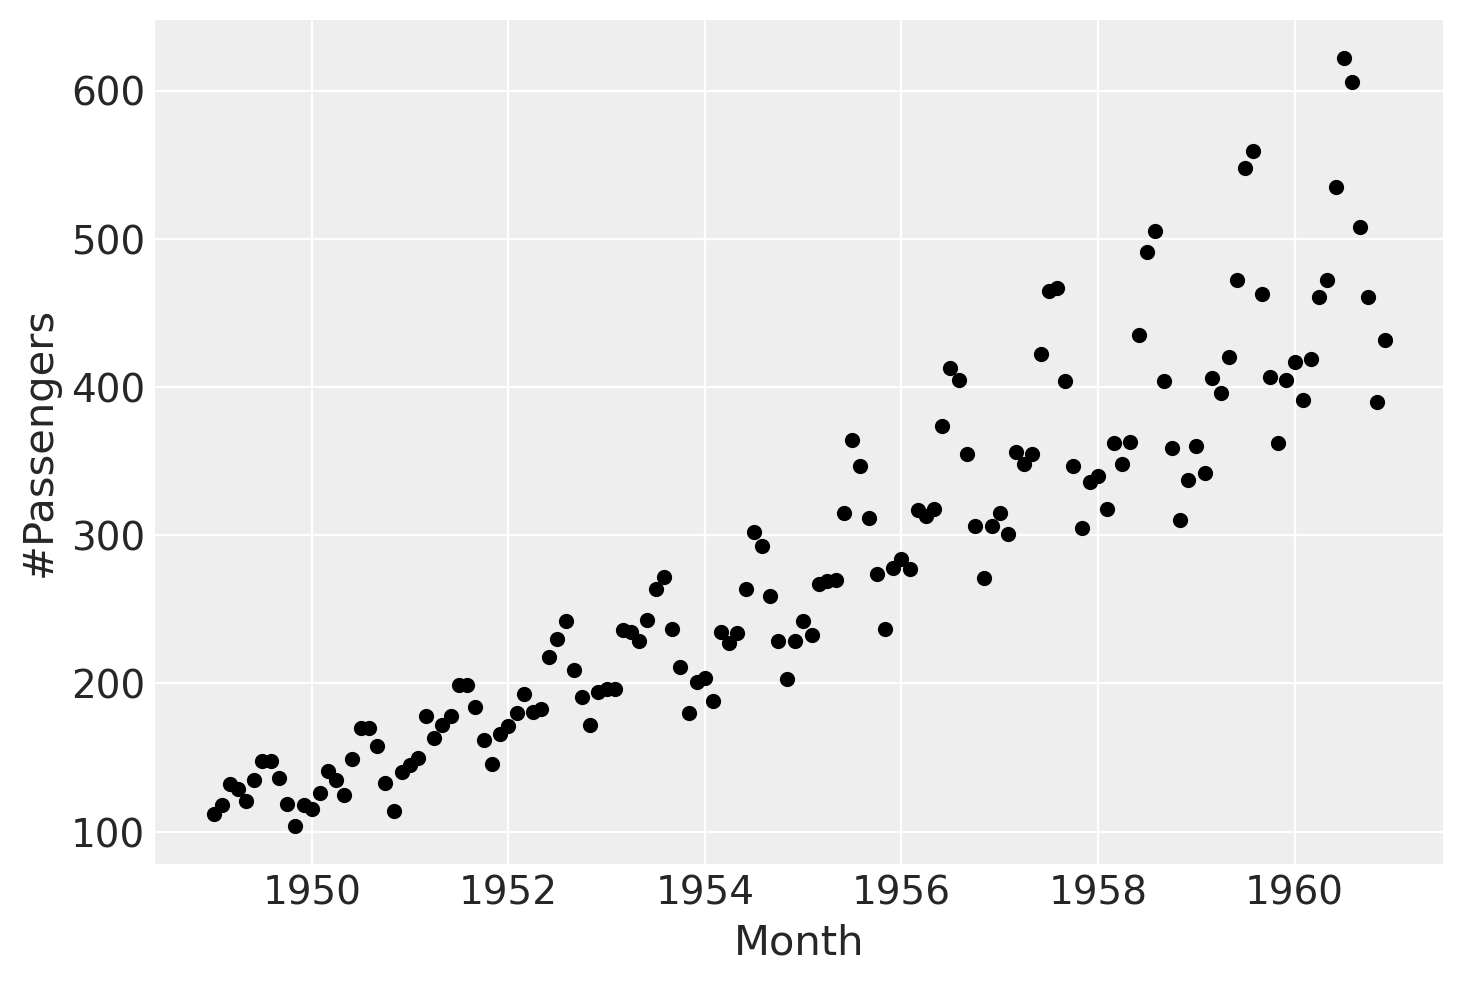

In [5]:
df.plot.scatter(x="Month", y="#Passengers", color="k");

There's an increasing trend, with multiplicative seasonality. We'll fit a linear trend, and "borrow" the multiplicative seasonality part of it from Prophet.

## Part 0: scale the data

First, we'll scale time to be between 0 and 1:

In [6]:
t = (df["Month"] - pd.Timestamp("1900-01-01")).dt.days.to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

Next, for the target variable, we divide by the maximum. We do this, rather than standardising, so that the sign of the observations in unchanged - this will be necessary for the seasonality component to work properly later on.

In [7]:
y = df["#Passengers"].to_numpy()
y_max = np.max(y)
y = y / y_max

## Part 1: linear trend

The model we'll fit, for now, will just be

$$\text{Passengers} \sim \alpha + \beta\ \text{time}$$

First, let's try using the default priors set by prophet, and we'll do a prior predictive check:

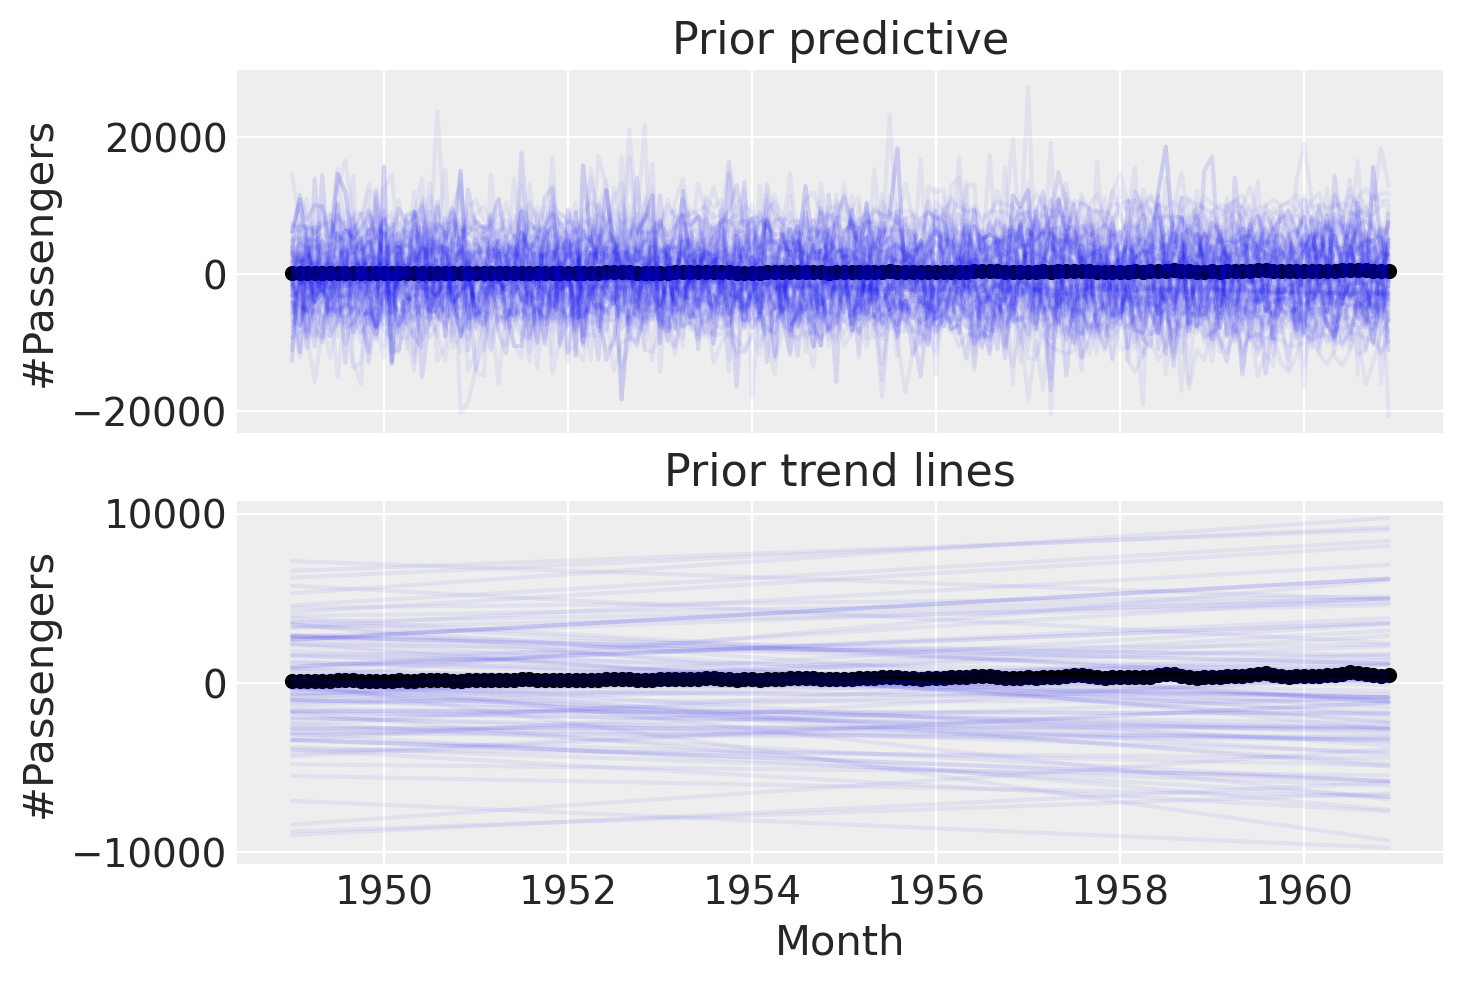

In [8]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=5)
    β = pm.Normal("β", mu=0, sigma=5)
    σ = pm.HalfNormal("σ", sigma=5)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior_predictive = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["Month"],
    _sample(linear_prior_predictive.prior_predictive["likelihood"].sel(chain=0), 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    _sample(linear_prior_predictive.prior["trend"].sel(chain=0), 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

We can do better than this. These priors are evidently too wide, as we end up with implausibly many passengers. Let's try setting tighter priors.

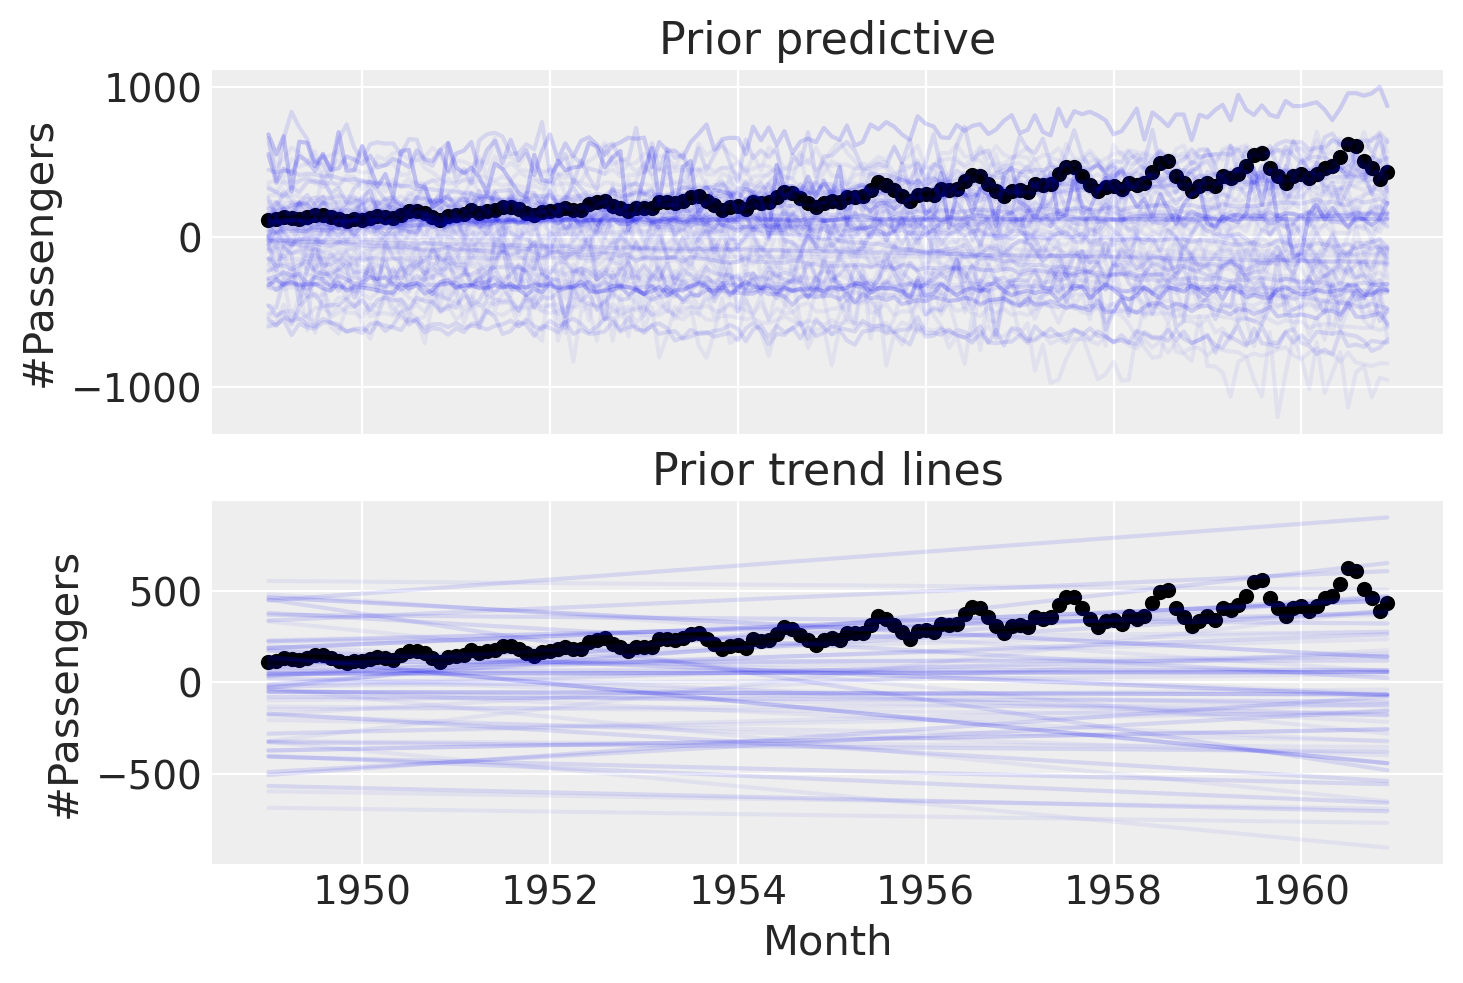

In [9]:
with pm.Model(check_bounds=False) as linear:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.1)
    trend = pm.Deterministic("trend", α + β * t)
    pm.Normal("likelihood", mu=trend, sigma=σ, observed=y)

    linear_prior_predictive = pm.sample_prior_predictive(samples=100)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["Month"],
    _sample(linear_prior_predictive.prior_predictive["likelihood"].sel(chain=0), 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    _sample(linear_prior_predictive.prior["trend"].sel(chain=0), 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

Cool. Before going on to anything more complicated, let's try conditioning on the data and doing a posterior predictive check:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8842, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8913, but should be close to 0.8. Try to increase the number of tuning steps.


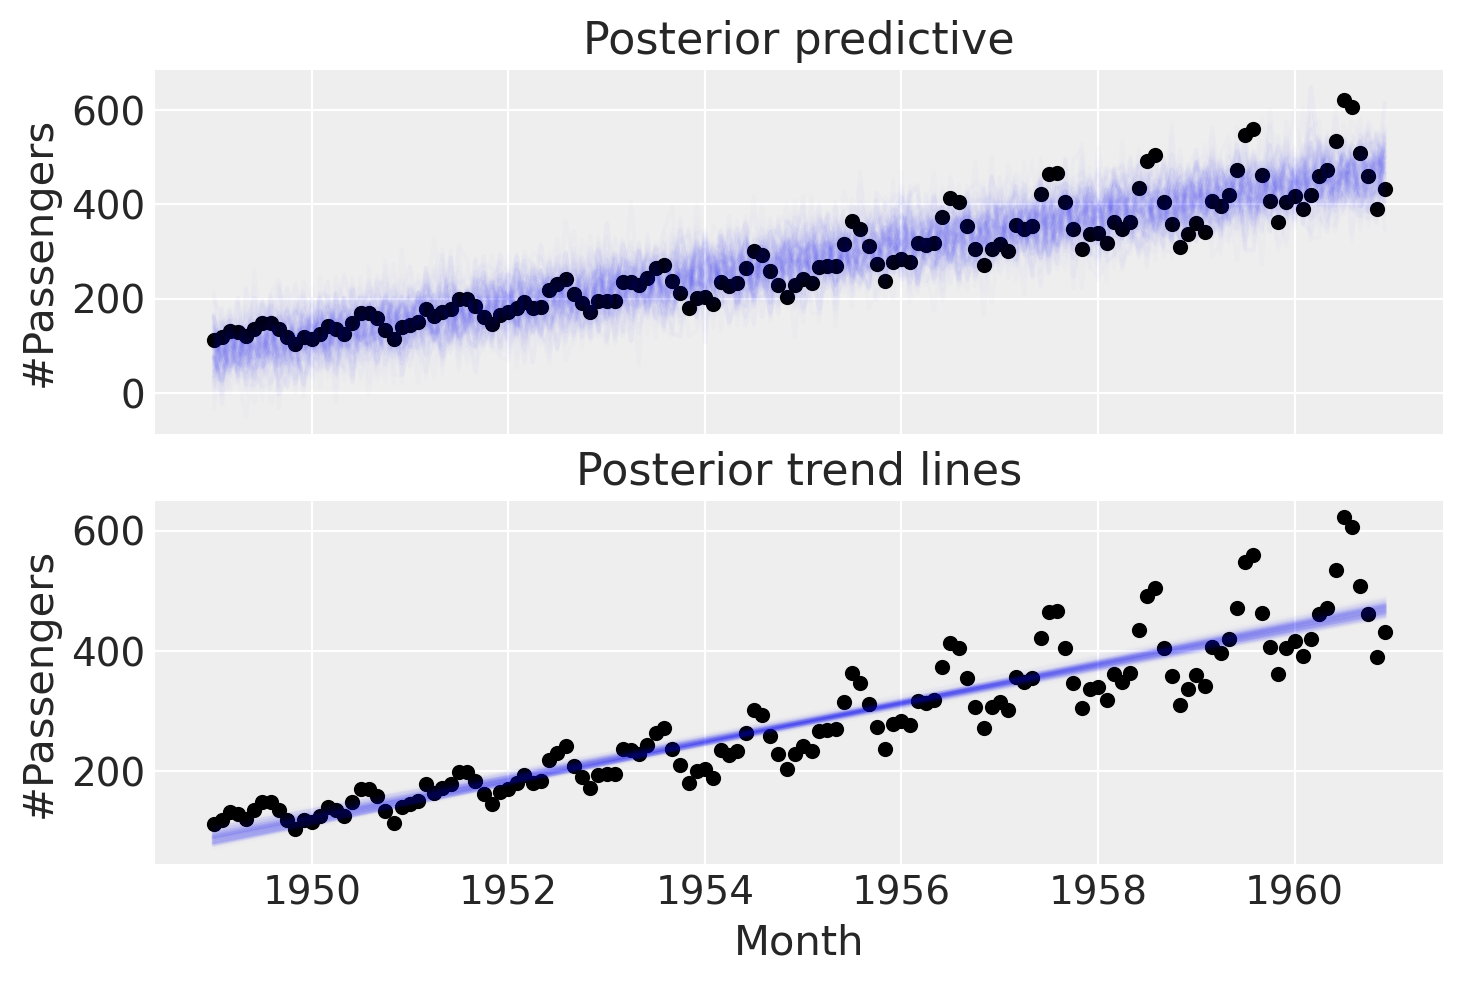

In [10]:
with linear:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_posterior_predictive = pm.sample_posterior_predictive(trace=linear_trace)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["Month"],
    _sample(linear_posterior_predictive.posterior_predictive["likelihood"].sel(chain=0), 100).T
    * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
posterior_trend = linear_trace.posterior["trend"].stack(sample=("draw", "chain")).T
ax[1].plot(df["Month"], _sample(posterior_trend, 100).T * y_max, color="blue", alpha=0.01)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");

## Part 2: enter seasonality

To model seasonality, we'll "borrow" the approach taken by Prophet - see [the Prophet paper](https://peerj.com/preprints/3190/) {cite:p}`taylor2018forecasting` for details, but the idea is to make a matrix of Fourier features which get multiplied by a vector of coefficients. As we'll be using multiplicative seasonality, the final model will be

$$\text{Passengers} \sim (\alpha + \beta\ \text{time}) (1 + \text{seasonality})$$

In [11]:
n_order = 10
periods = (df["Month"] - pd.Timestamp("1900-01-01")).dt.days / 365.25

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
fourier_features

,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4,sin_order_5,cos_order_5,sin_order_6,cos_order_6,sin_order_7,cos_order_7,sin_order_8,cos_order_8,sin_order_9,cos_order_9,sin_order_10,cos_order_10
0,-0.004301,0.999991,-0.008601,0.999963,-0.012901,0.999917,-0.017202,0.999852,-0.021501,0.999769,-0.025801,0.999667,-0.030100,0.999547,-0.034398,0.999408,-0.038696,0.999251,-0.042993,0.999075
1,0.504648,0.863325,0.871351,0.490660,0.999870,-0.016127,0.855075,-0.518505,0.476544,-0.879150,-0.032249,-0.999480,-0.532227,-0.846602,-0.886721,-0.462305,-0.998830,0.048363,-0.837909,0.545811
2,0.847173,0.531317,0.900235,-0.435405,0.109446,-0.993993,-0.783934,-0.620844,-0.942480,0.334263,-0.217577,0.976043,0.711276,0.702913,0.973402,-0.229104,0.323093,-0.946367,-0.630072,-0.776537
3,0.999639,0.026876,0.053732,-0.998555,-0.996751,-0.080549,-0.107308,0.994226,0.990983,0.133990,0.160575,-0.987024,-0.982352,-0.187043,-0.213377,0.976970,0.970882,0.239557,0.265563,-0.964094
4,0.882712,-0.469915,-0.829598,-0.558361,-0.103031,0.994678,0.926430,-0.376467,-0.767655,-0.640864,-0.204966,0.978769,0.960288,-0.279012,-0.697540,-0.716546,-0.304719,0.952442,0.983924,-0.178587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-0.484089,-0.875019,0.847173,0.531317,-0.998497,-0.054805,0.900235,-0.435405,-0.576948,0.816781,0.109446,-0.993993,0.385413,0.922744,-0.783934,-0.620844,0.986501,0.163757,-0.942480,0.334263
140,-0.861693,-0.507430,0.874498,-0.485029,-0.025801,0.999667,-0.848314,-0.529494,0.886721,-0.462305,-0.051584,0.998669,-0.834370,-0.551205,0.898354,-0.439273,-0.077334,0.997005,-0.819871,-0.572548
141,-0.999870,-0.016127,0.032249,-0.999480,0.998830,0.048363,-0.064464,0.997920,-0.996751,-0.080549,0.096613,-0.995322,0.993635,0.112651,-0.128661,0.991689,-0.989485,-0.144636,0.160575,-0.987024
142,-0.869233,0.494403,-0.859503,-0.511131,0.019352,-0.999813,0.878637,-0.477489,0.849450,0.527668,-0.038696,0.999251,-0.887713,0.460397,-0.839080,-0.544008,0.058026,-0.998315,0.896456,-0.443132


Again, let's use the default Prophet priors, just to see what happens.

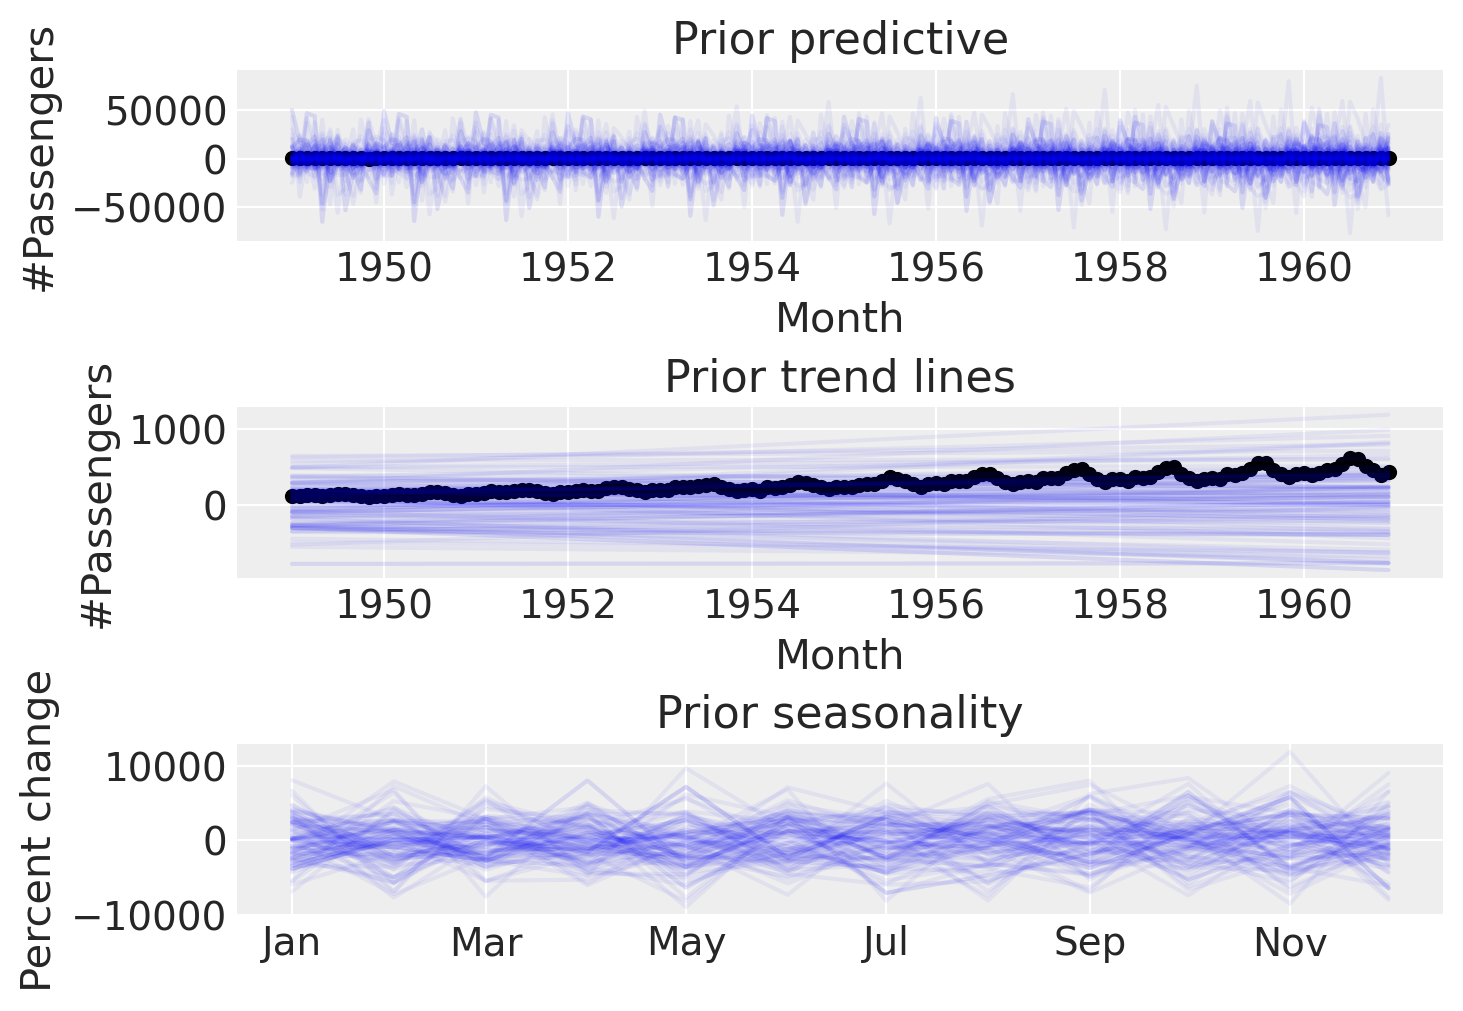

In [12]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    σ = pm.HalfNormal("σ", sigma=0.1)
    β_fourier = pm.Normal("β_fourier", mu=0, sigma=10, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_features.to_numpy().T)
    )
    trend = pm.Deterministic("trend", α + β * t)
    μ = trend * (1 + seasonality)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_with_seasonality_prior_predictive = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False)
ax[0].plot(
    df["Month"],
    _sample(
        linear_with_seasonality_prior_predictive.prior_predictive["likelihood"].sel(chain=0), 100
    ).T
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    _sample(linear_with_seasonality_prior_predictive.prior["trend"].sel(chain=0), 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    df["Month"].iloc[:12],
    _sample(
        linear_with_seasonality_prior_predictive.prior["seasonality"].sel(chain=0)[:, :12], 100
    ).T
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);

Again, this seems implausible. The default priors are too wide for our use-case, and it doesn't make sense to use them when we can do prior predictive checks to set more sensible ones. Let's try with some narrower ones:

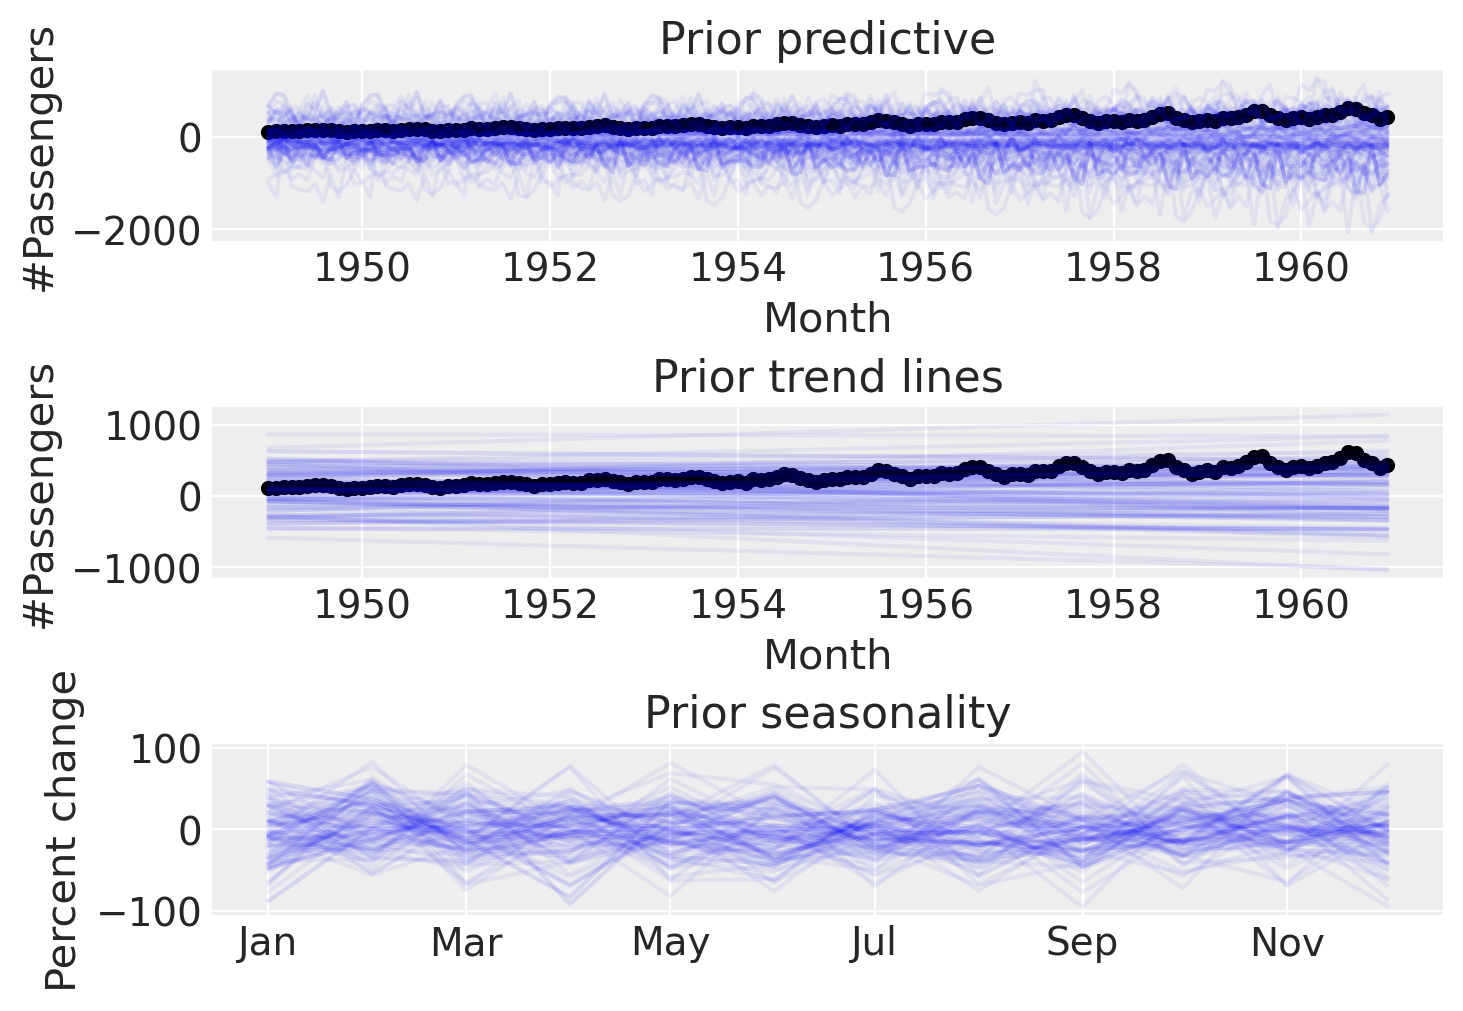

In [13]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    α = pm.Normal("α", mu=0, sigma=0.5)
    β = pm.Normal("β", mu=0, sigma=0.5)
    trend = pm.Deterministic("trend", α + β * t)

    β_fourier = pm.Normal("β_fourier", mu=0, sigma=0.1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_features.to_numpy().T)
    )

    μ = trend * (1 + seasonality)
    σ = pm.HalfNormal("σ", sigma=0.1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y)

    linear_with_seasonality_prior_predictive = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False)
ax[0].plot(
    df["Month"],
    _sample(
        linear_with_seasonality_prior_predictive.prior_predictive["likelihood"].sel(chain=0), 100
    ).T
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    _sample(linear_with_seasonality_prior_predictive.prior["trend"].sel(chain=0), 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    df["Month"].iloc[:12],
    _sample(
        linear_with_seasonality_prior_predictive.prior["seasonality"].sel(chain=0)[:, :12], 100
    ).T
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);

Seems a lot more believable. Time for a posterior predictive check:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, β_fourier, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


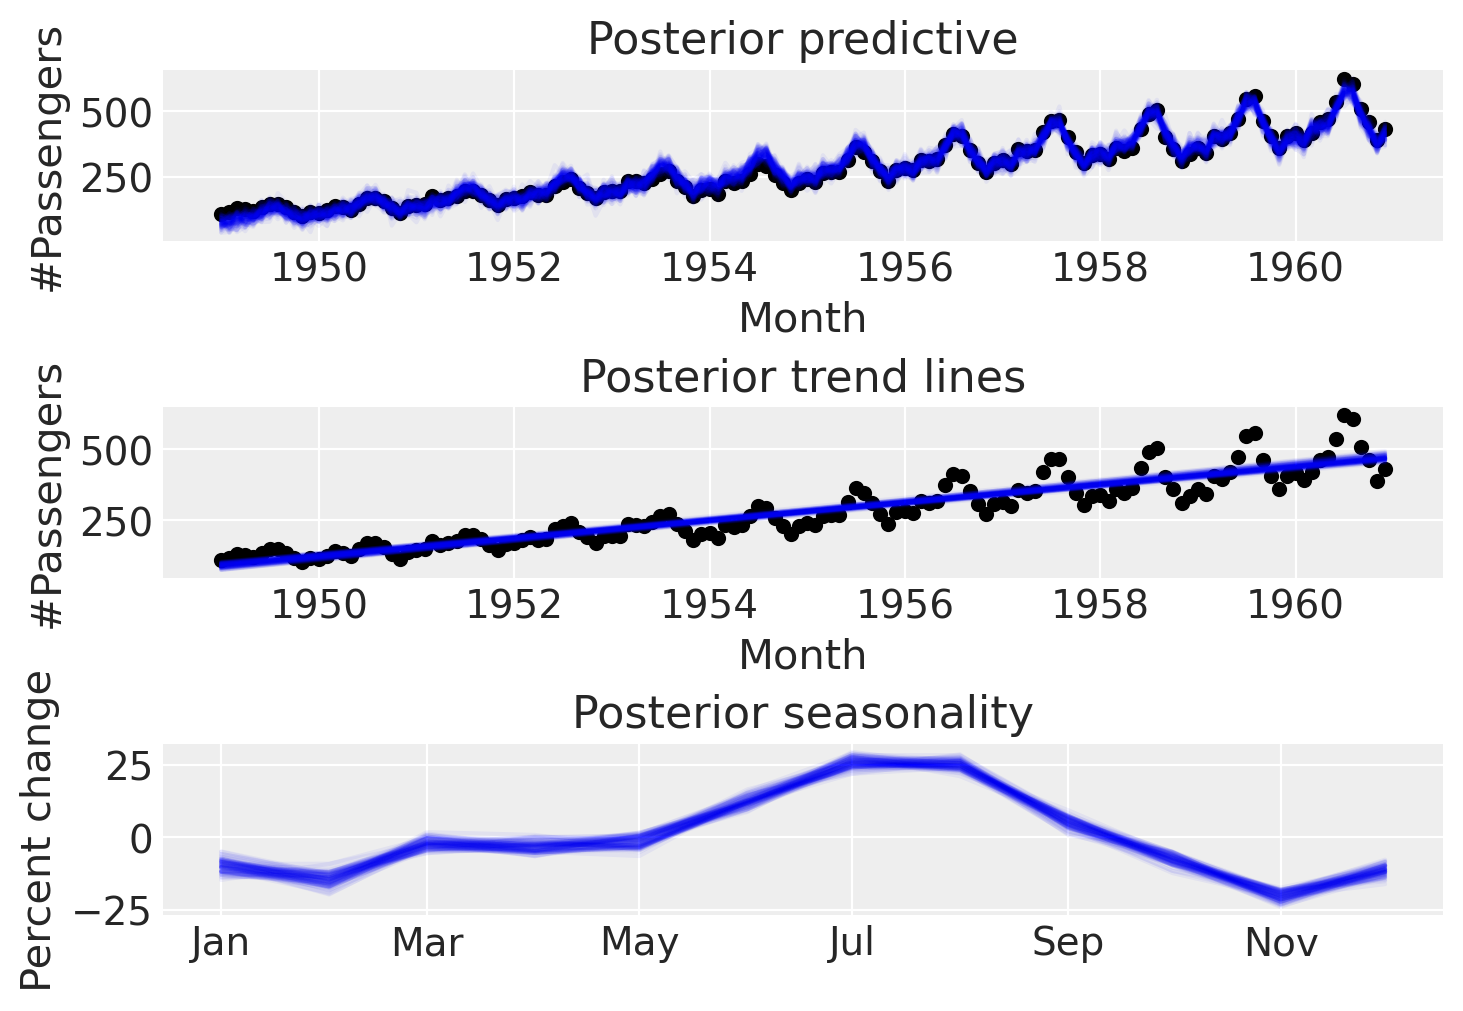

In [14]:
with linear_with_seasonality:
    linear_with_seasonality_trace = pm.sample(return_inferencedata=True)
    linear_with_seasonality_posterior_predictive = pm.sample_posterior_predictive(
        trace=linear_with_seasonality_trace
    )

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False)
ax[0].plot(
    df["Month"],
    _sample(
        linear_with_seasonality_posterior_predictive.posterior_predictive["likelihood"].sel(
            chain=0
        ),
        100,
    ).T
    * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
posterior_trend = linear_trace.posterior["trend"].stack(sample=("draw", "chain")).T
ax[1].plot(df["Month"], _sample(posterior_trend, 100).T * y_max, color="blue", alpha=0.05)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines")
posterior_seasonality = (
    linear_with_seasonality_trace.posterior["seasonality"].stack(sample=("draw", "chain")).T
)
ax[2].plot(
    df["Month"].iloc[:12],
    _sample(posterior_seasonality[:, :12], 100).T * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Posterior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter);

Neat!

## Conclusion

We saw how we could implement a Prophet-like model ourselves and fit it to the air passengers dataset. Prophet is an awesome library and a net-positive to the community, but by implementing it ourselves, however, we can take whichever components of it we think are relevant to our problem, customise them, and carry out the Bayesian workflow {cite:p}`gelman2020bayesian`). Next time you have a time series problem, I hope you will try implementing your own probabilistic model rather than using Prophet as a "black-box" whose arguments are tuneable hyperparameters.

For reference, you might also want to check out:
- [TimeSeeers](https://github.com/MBrouns/timeseers), a hierarchical Bayesian Time Series model based on Facebooks Prophet, written in PyMC3
- [PM-Prophet](https://github.com/luke14free/pm-prophet), a Pymc3-based universal time series prediction and decomposition library inspired by Facebook Prophet

## Authors
* Authored by [Marco Gorelli](https://github.com/MarcoGorelli) in June, 2021 ([pymc-examples#183](https://github.com/pymc-devs/pymc-examples/pull/183))
* Re-executed by Danh Phan in May, 2022 ([pymc-examples#320](https://github.com/pymc-devs/pymc-examples/pull/320))

## References
:::{bibliography}
:filter: docname in docnames
:::

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Sat May 14 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

aesara: 2.6.2
aeppl : 0.0.28
xarray: 2022.3.0

matplotlib: 3.5.1
pymc      : 4.0.0b6
pandas    : 1.4.1
arviz     : 0.12.0
numpy     : 1.22.3

Watermark: 2.3.0

